In [34]:
# pipeline based on the book

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import skimage as ski
from skimage.feature import hog

from infrabel_ml.transformers import HogTransformer, RGB2GrayTransformer, Images1dTransformer
from infrabel_ml.utils import normalised_cmx
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

In [4]:
def show_image_by_idx(n):
    plt.imshow(data['data'][n])
    plt.axis("off")
    plt.suptitle(data['label'][n])

## Load data
Load the data as processed using resize_equipment_photos

dict_keys(['description', 'label', 'filename', 'data'])
resized (102x136)equipment images in rgb


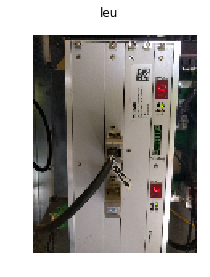

In [5]:
data = joblib.load('equipment_photos_102x136px.pkl')
print(data.keys())
print(data['description'])
show_image_by_idx(0)

X = np.array(data['data'])
y = np.array(data['label'])
fn = np.array(data['filename'])

## Prepare data set
The dataset is ordered by equipment type, so it needs to be shuffled. We use train_test_split with the shuffle parameter to obtain a 80:20 training:test set 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

len(X_train)

2212

Use pipelines to streamline the process of pre-processing and training. Note that self build data transformers can be easily incoorporated. See for example the Hogtransformer.

In [7]:

HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer()),
    ('scalify', StandardScaler())
])


# LDA_pipeline = Pipeline([
#     ('grayify', RGB2GrayTranformer()),
#     ('onedeeify', Images1dTransformer()),
#     ('lda', LinearDiscriminantAnalysis()),
#     ('scalify', StandardScaler())
# ])

# PCA_pipeline = Pipeline([
#     ('grayify', RGB2GrayTranformer()),
#     ('onedeeify', Images1dTransformer()),
#     ('pcaify', PCATransformer(n_components=6)),
#     ('scalify', StandardScaler())
# ])

X_train_prepared = HOG_pipeline.fit_transform(X_train, y=y_train)

# X_train_prepared = grayhog_pipeline.fit_transform(X_train)

# Models and such

In [8]:
def test_run(classifier, X_train, y_train, method='accuracy', classifier_string=''):
    clf = classifier
    y_train_predict = cross_val_predict(clf, X_train, y_train, cv=3)#, method='predict_proba')
    print(classifier_string, cross_val_score(clf, X_train, y_train, cv=3))
    normalised_cmx(y_train, y_train_predict, show=True, zero_diag=True)

## SGD

sgd [ 0.90135135  0.88331072  0.88707483]
['jade' 'leu' 'plp' 'plpcomm' 'polar' 'relais']


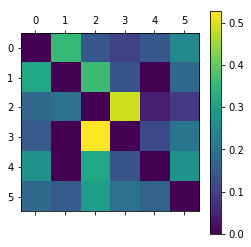

In [9]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
test_run(sgd_clf, X_train_prepared, y_train, classifier_string='sgd')
plt.colorbar()

## Random forest

 [ 0.82027027  0.81275441  0.80544218]
['jade' 'leu' 'plp' 'plpcomm' 'polar' 'relais']


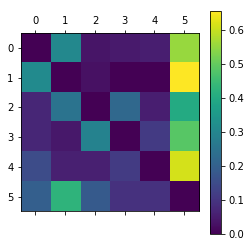

In [13]:
forest_clf = RandomForestClassifier(random_state=42)
test_run(forest_clf, X_train_prepared, y_train)
plt.colorbar()

## GradientBoostingClassifier

In [16]:
# gradient_boost_clf = GradientBoostingClassifier()
# test_run(gradient_boost_clf, X_train_prepared, y_train)

# Grid search

In [245]:
# param_grid = [
#     {'n_estimators': [10, 30, 100], 'max_features': [8, 16, 24]},
#     {'bootstrap': [False], 'n_estimators': [10, 30], 'max_features': [8, 16, 24]},
#   ]

param_grid = [
    {'kernel': ['linear', 'poly']},
    {'decision_function_shape': ['ovo', 'ovr']}
]

forest_clf = RandomForestClassifier(random_state=42)

cvm_clf = svm.SVC()

grid_search = GridSearchCV(cvm_clf, 
                           param_grid, 
                           cv=3,
                           scoring='accuracy')

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear']}, {'decision_function_shape': ['ovo', 'ovr']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [248]:
grid_search.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
# ## Test set
# fm = grid_search.best_estimator_
# X_test_prepared = HOG_pipeline.transform(X_test)
# final_predictions = fm.predict(X_test_prepared)




In [ ]:
forest_clf = RandomForestClassifier(random_state=42, bootstrap=False, max_features=24, n_estimators=300)
y_train_predict_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)#, method='predict_proba')
print(cross_val_score(forest_clf, X_train_prepared, y_train, cv=3))
normalised_cmx(y_train, y_train_predict_forest, show=True, zero_diag=True)

Don’t forget that you can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature you were not sure about (e.g., using the add_bedrooms_per_room hyperparameter of your CombinedAttributesAdder transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.

# Complete pipeline

In [91]:
# Parallel werkt nu wel? Waarom?

HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer()),
    ('scalify', StandardScaler()),
    ('classify', svm.SVC(kernel='linear'))
])

param_grid = [
    {'hogify__orientations': [9, 13],
    'hogify__cells_per_block': [(3,3), (5,5), (7,7)],
    'hogify__pixels_per_cell': [(8,8), (12,12), (14,14)]}
]

grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=3,
                           scoring='accuracy',
                          verbose=2)

random_grid = {'hogify__orientations': [8, 9, 10],
    'hogify__cells_per_block': [(2, 2), (3,3), (4,4)],
    'hogify__pixels_per_cell': [(10,10), (12, 12), (14, 14), (16,16), (18,18)]
}


random_search = RandomizedSearchCV(
    HOG_pipeline, 
    random_grid,
    n_iter=30,
    cv=3, 
    n_jobs=-1, 
    scoring='accuracy', 
    verbose=2
)

# cvres = grid_search.fit(X_train, y_train)
# X_train_prepared = grayhog_pipeline.fit_transform(X_train)
# cvres
# joblib.dump(cvres, 'cvres.pkl')

random_res = random_search.fit(X_train, y_train)
# X_train_prepared = grayhog_pipeline.fit_transform(X_train)

joblib.dump(random_res, 'random_res.pkl')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] hogify__pixels_per_cell=(10, 10), hogify__orientations=8, hogify__cells_per_block=(2, 2) 
[CV] hogify__pixels_per_cell=(10, 10), hogify__orientations=8, hogify__cells_per_block=(2, 2) 
[CV] hogify__pixels_per_cell=(10, 10), hogify__orientations=8, hogify__cells_per_block=(2, 2) 
[CV] hogify__pixels_per_cell=(16, 16), hogify__orientations=8, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(16, 16), hogify__orientations=8, hogify__cells_per_block=(4, 4), total=  12.1s
[CV] hogify__pixels_per_cell=(16, 16), hogify__orientations=8, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(16, 16), hogify__orientations=8, hogify__cells_per_block=(4, 4), total=  11.6s
[CV] hogify__pixels_per_cell=(16, 16), hogify__orientations=8, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(10, 10), hogify__orientations=8, hogify__cells_per_block=(2, 2), total=  25.3s
[CV] hogify__pixels_per_cell=(18, 18), 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min


[CV]  hogify__pixels_per_cell=(16, 16), hogify__orientations=10, hogify__cells_per_block=(4, 4), total=  13.1s
[CV] hogify__pixels_per_cell=(14, 14), hogify__orientations=9, hogify__cells_per_block=(3, 3) 
[CV]  hogify__pixels_per_cell=(10, 10), hogify__orientations=10, hogify__cells_per_block=(2, 2), total=  29.0s
[CV] hogify__pixels_per_cell=(14, 14), hogify__orientations=9, hogify__cells_per_block=(3, 3) 
[CV]  hogify__pixels_per_cell=(16, 16), hogify__orientations=10, hogify__cells_per_block=(4, 4), total=  13.7s
[CV] hogify__pixels_per_cell=(16, 16), hogify__orientations=9, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(14, 14), hogify__orientations=9, hogify__cells_per_block=(3, 3), total=  16.0s
[CV] hogify__pixels_per_cell=(16, 16), hogify__orientations=9, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(14, 14), hogify__orientations=9, hogify__cells_per_block=(3, 3), total=  16.0s
[CV] hogify__pixels_per_cell=(16, 16), hogify__orientations=9, hogi

[CV]  hogify__pixels_per_cell=(10, 10), hogify__orientations=10, hogify__cells_per_block=(4, 4), total=  45.6s
[CV] hogify__pixels_per_cell=(10, 10), hogify__orientations=9, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(14, 14), hogify__orientations=10, hogify__cells_per_block=(3, 3), total=  17.5s
[CV] hogify__pixels_per_cell=(14, 14), hogify__orientations=8, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(14, 14), hogify__orientations=8, hogify__cells_per_block=(4, 4), total=  15.9s
[CV] hogify__pixels_per_cell=(14, 14), hogify__orientations=8, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(10, 10), hogify__orientations=9, hogify__cells_per_block=(4, 4), total=  39.9s
[CV] hogify__pixels_per_cell=(14, 14), hogify__orientations=8, hogify__cells_per_block=(4, 4) 
[CV]  hogify__pixels_per_cell=(10, 10), hogify__orientations=9, hogify__cells_per_block=(4, 4), total=  39.8s
[CV] hogify__pixels_per_cell=(18, 18), hogify__orientations=9, hogif

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 12.9min finished


['random_res.pkl']

In [93]:
random_res.best_params_

{'hogify__cells_per_block': (4, 4),
 'hogify__orientations': 9,
 'hogify__pixels_per_cell': (12, 12)}

In [94]:
cvres = random_res.cv_results_

print('time', 'mean_score', 'ppc', 'orientations', 'cpb')
for mean_fit_time, mean_score, params in zip(cvres['mean_fit_time'], cvres['mean_test_score'], cvres['params']):
    print(mean_fit_time, mean_score, params.values())

time mean_score ppc orientations cpb
17.1419637998 0.903707052441 dict_values([(10, 10), 8, (2, 2)])
8.43260733287 0.927215189873 dict_values([(16, 16), 8, (4, 4)])
8.33313218753 0.921338155515 dict_values([(18, 18), 9, (3, 3)])
16.9911169211 0.939421338156 dict_values([(12, 12), 9, (3, 3)])
7.14019012451 0.917721518987 dict_values([(18, 18), 8, (4, 4)])
7.93390639623 0.926311030741 dict_values([(18, 18), 10, (4, 4)])
15.4357953072 0.919529837251 dict_values([(12, 12), 9, (2, 2)])
11.7514692942 0.927215189873 dict_values([(14, 14), 9, (2, 2)])
7.59249377251 0.927215189873 dict_values([(18, 18), 9, (4, 4)])
7.26963671048 0.912748643761 dict_values([(18, 18), 8, (3, 3)])
19.4965951443 0.912296564195 dict_values([(10, 10), 10, (2, 2)])
8.88400650024 0.933092224231 dict_values([(16, 16), 10, (4, 4)])
10.9070611 0.943037974684 dict_values([(14, 14), 9, (3, 3)])
8.49001399676 0.936256781193 dict_values([(16, 16), 9, (4, 4)])
8.29617389043 0.923598553345 dict_values([(16, 16), 8, (2, 2)])
22.

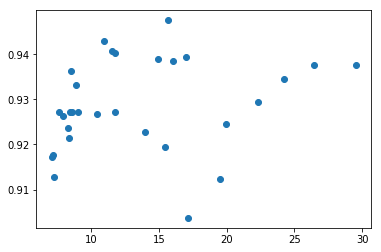

In [96]:
plt.plot(cvres['mean_fit_time'], cvres['mean_test_score'], 'o')

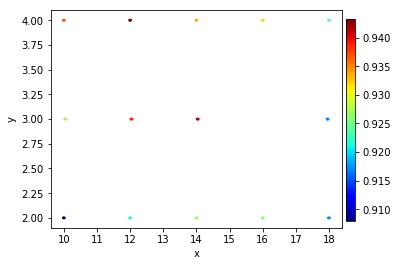

In [118]:
fig, ax = plt.subplots()
# fig.set_size_inches(15,3)
im = ax.hexbin(ppc, cpb, cvres['mean_test_score'], cmap='jet', bins=None,)
ax.set_xlabel('x')
ax.set_ylabel('y')
#     cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [ ]:
plt.plot(cvres['mean_fit_time'], cvres['mean_test_score'], 'o')

In [110]:
cpb = []
ori = []
ppc = []

for d in cvres['params']:
    cpb.append(d['hogify__cells_per_block'][0])
    ori.append(d['hogify__orientations'])
    ppc.append(d['hogify__pixels_per_cell'][0])

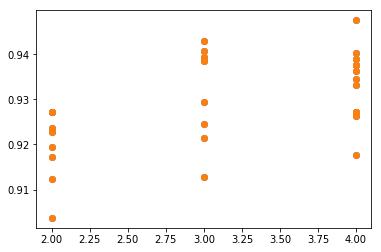

In [100]:
plt.plot(cpb, cvres['mean_test_score'], 'o')

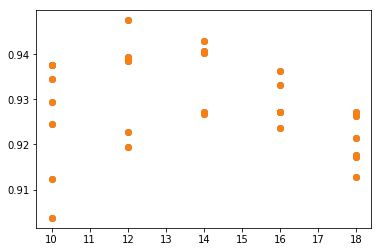

In [102]:
plt.plot(ppc, cvres['mean_test_score'], 'o')

In [90]:
random_res.cv_results_

{'mean_fit_time': array([ 16.83348052,  27.54321082,  17.50698431,  11.12501804,
         14.81350295,   7.33447782,   8.36598802,  12.02260733,
         11.7247471 ,   8.70679585]),
 'mean_score_time': array([  9.24662105,  11.97029034,   8.58401799,   6.08160845,
          7.56384412,   3.70592809,   4.11486475,   6.1471897 ,
          6.07234804,   4.17559711]),
 'mean_test_score': array([ 0.93942134,  0.92721519,  0.93851718,  0.92721519,  0.93309222,
         0.90687161,  0.92721519,  0.9403255 ,  0.94168174,  0.93716094]),
 'mean_train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'param_hogify__cells_per_block': masked_array(data = [(3, 3) (3, 3) (3, 3) (2, 2) (3, 3) (2, 2) (4, 4) (4, 4) (4, 4) (3, 3)],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_hogify__orientations': masked_array(data = [9 10 10 9 8 8 8 10 9 9],
              mask = [False False False False False False False False Fa

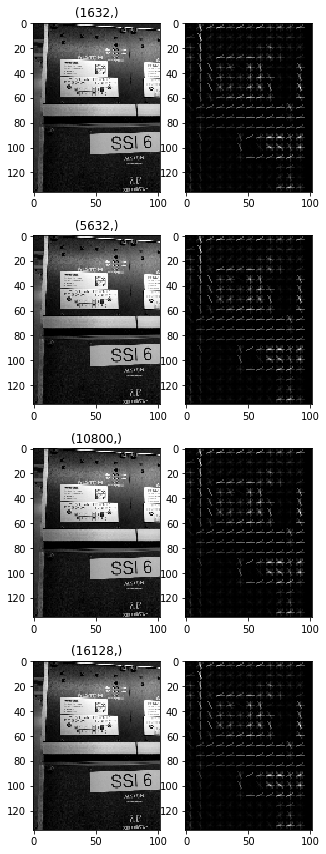

In [71]:
gray = ski.color.rgb2gray(X_train[0])


fig, ax = plt.subplots(4, 2)
fig.set_size_inches(5, 15)

hog_desc, hog_img = hog(gray, orientations=8, cells_per_block=(1, 1), pixels_per_cell=(8, 8), block_norm='L2-Hys', visualise=True)
ax[0,0].imshow(gray, cmap='gray')
ax[0,1].imshow(hog_img, cmap='gray')
ax[0,0].set_title(hog_desc.shape)

hog_desc, hog_img = hog(gray, orientations=8, cells_per_block=(2, 2), pixels_per_cell=(8, 8), block_norm='L2-Hys', visualise=True)
ax[1,0].imshow(gray, cmap='gray')
ax[1,1].imshow(hog_img, cmap='gray')
ax[1,0].set_title(hog_desc.shape)

hog_desc, hog_img = hog(gray, orientations=8, cells_per_block=(3, 3), pixels_per_cell=(8, 8), block_norm='L2-Hys', visualise=True)
ax[2,0].imshow(gray, cmap='gray')
ax[2,1].imshow(hog_img, cmap='gray')
ax[2,0].set_title(hog_desc.shape)

hog_desc, hog_img = hog(gray, orientations=8, cells_per_block=(4,4), pixels_per_cell=(8, 8), block_norm='L2-Hys', visualise=True)
ax[3,0].imshow(gray, cmap='gray')
ax[3,1].imshow(hog_img, cmap='gray')
ax[3,0].set_title(hog_desc.shape)

In [19]:
random_res.best_params_

{'hogify__cells_per_block': (3, 3),
 'hogify__orientations': 9,
 'hogify__pixels_per_cell': (14, 14)}

In [ ]:
random_forest_pipeline = Pipeline([
    ('grayify', RGB2GrayTranformer()),
    ('hogify', HogTransformer()),
    ('scalify', StandardScaler()),
    ('classify', RandomForestClassifier(random_state=42))
])

param_grid = [
     {'hogify': [PCATransformer()],
      'classify__n_estimators': [2, 4], 
      'classify__max_features': [3, 6]},
  ]

In [276]:
fm = grid_search.best_estimator_
fm

Pipeline(memory=None,
     steps=[('grayify', RGB2GrayTranformer()), ('hogify', HogTransformer(block_norm='L2-Hys', cells_per_block=(5, 5), orientations=9,
        pixels_per_cell=(12, 12), y=None)), ('scalify', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [277]:
final_predictions = fm.predict(X_test)

# load pickled model

13872

In [5]:
cvres = joblib.load('cvres.pkl')

In [6]:
cvres.best_params_

{'hogify__cells_per_block': (3, 3),
 'hogify__orientations': 9,
 'hogify__pixels_per_cell': (14, 14)}

In [9]:
# ## Test set
fm = cvres.best_estimator_
# X_test_prepared = HOG_pipeline.transform(X_test)
final_predictions = fm.predict(X_test)

In [10]:
# prep

HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(cells_per_block=(3, 3), orientations=9, pixels_per_cell=(14,14))),
    ('scalify', StandardScaler()),
#     ('classify', svm.SVC(kernel='linear'))
])

X_train_prepared = HOG_pipeline.fit_transform(X_train, y_train)
X_train_prepared_reshaped = X_train_prepared[:, np.newaxis, :]

X_test_prepared = HOG_pipeline.fit_transform(X_test, y_test)
X_test_prepared_reshaped = X_test_prepared[:, np.newaxis, :]

ohv = LabelBinarizer()
ohv.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [12]:

def foo():
    
    mse_train = []
    mse_test = []
        
    for n in range(2, 1002, 50):
        print(n)


        mod = svm.SVC(kernel='linear')
        mod.fit(X_train_prepared[:n], y_train[:n])

        pred_train = mod.predict(X_train_prepared[:n])
        pred_test = mod.predict(X_test_prepared)

        mse_train.append(mean_squared_error(ohv.transform(y_train[:n]), ohv.transform(pred_train)))
        mse_test.append(mean_squared_error(ohv.transform(y_test), ohv.transform(pred_test)))
        
    return mse_train, mse_test
    
    plt.plot(mse_train, label='train')
    plt.plot(mse_test, label='test')

        
#     mean_squared_error(y_test[:n], pred_train[:n])
    
mse_train, mse_test = foo()

2
52
102
152
202
252
302
352
402
452
502
552
602
652
702
752
802
852
902
952


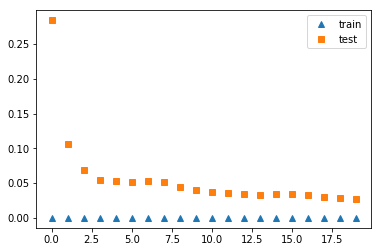

In [13]:
plt.plot(mse_train, '^', label='train')
plt.plot(mse_test, 's', label='test')
plt.legend()

impedance, zou iedere element een feature zijn.Train het model en de parameters voor de features zijn eigenlijk je fit en daarmee je model.

In [102]:
mean_squared_error(mod.predict(X_train_prepared_reshaped, ))

array(['polar'],
      dtype='<U7')

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

(2835, 1)

In [27]:
a = np.array([1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4])

In [19]:
from numpy.random import random, shuffle

In [25]:
random(np.arange(len(a)))

array([], shape=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19), dtype=float64)

In [29]:
len(a)

20

In [28]:
print(a)

[1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]
